In [24]:
%matplotlib inline
import os, re
from PIL import Image
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

path = 'C:/Users/WangHua/Pictures/water_images/'


def var(rd):    # 求颜色通道的三阶颜色矩
    mid = np.mean((rd-rd.mean())**3)
    return np.sign(mid)*abs(mid)**(1/3)

In [8]:
def get_img_names(path=path):     #将图片从文件夹中提取
    file_names = os.listdir(path)
    img_names = []
    for i in file_names:
        if re.findall('^\d_\d+\.jpg$', i) != []:
            img_names.append(i)
    return img_names


In [9]:
def get_img_data(path=path):
    img_names = get_img_names(path=path)
    n = len(img_names)
    data = np.zeros([n, 9])
    labels = np.zeros([n])
    for i in range(n):
        img = Image.open(path+img_names[i])  # 读取图片数据
        M, N = img.size                      # 像素矩阵的行列数
        region = img.crop((M/2-50, N/2-50, M/2+50, N/2+50))  # 截取图像的中心区域

        r, g, b = region.split()   # 分割像素通道
        rd = np.asarray(r)    # 将图片数据转换为数组
        gd = np.asarray(g)
        bd = np.asarray(b)

        data[i, 0] = rd.mean()   # 一阶颜色矩
        data[i, 1] = gd.mean()
        data[i, 2] = bd.mean()

        data[i, 3] = rd.std()    # 二阶颜色矩
        data[i, 4] = gd.std()
        data[i, 5] = bd.std()

        data[i, 6] = var(rd)     # 三阶颜色矩
        data[i, 7] = var(gd)
        data[i, 8] = var(bd)

        labels[i] = img_names[i][0]
    return data, labels

In [12]:
data, labels = get_img_data()    # 数据预处理之后，得到特征数为9的数据

0.775

Text(0, 0.5, 'Second principal component')

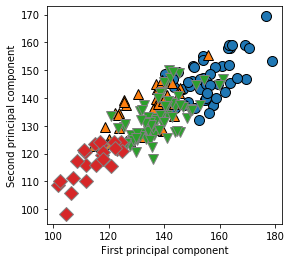

In [26]:
mglearn.discrete_scatter(data[:, 0], data[:, 1], labels)  #图像分析，确定data与label有一定的关系
 
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")  

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(data).transform(data)  #将得出的data做MinMaxScaler处理

In [44]:
data_tr, data_te, labels_tr, labels_te = train_test_split(data_scaled, labels, test_size=0.2)  # 将数据拆分为训练集和测试集
Dtc = DecisionTreeClassifier().fit(data_tr, labels_tr)  # 采用决策树模型训练
pre = Dtc.predict(data_te)   # 模型预测

print("决策树模型精度为: ", sum(pre==labels_te)/len(pre))            # 预测精度


决策树模型精度为:  0.875


In [41]:
from sklearn.svm import SVC  
X_trainval, X_test, y_trainval, y_test = train_test_split(
    data_scaled, labels, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("训练集大小: {}  验证集大小: {}   测试集大小:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0   

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:

        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)

        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}     #筛选最大值

svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("验证集上的最佳精度: {:.2f}".format(best_score))
print("最好的参数: ", best_parameters)
print("最佳参数的精度: {:.2f}".format(test_score))

训练集大小: 110  验证集大小: 37   测试集大小: 50

验证集上的最佳精度: 0.95
最好的参数:  {'C': 100, 'gamma': 1}
最佳参数的精度: 0.90
